In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
from dataclasses import dataclass, field
from statistics import geometric_mean
from typing import DefaultDict
from collections import defaultdict


@dataclass
class TraceStat:
    insn: int
    cycles: int
    miss: int
    hits: int
    hit_rate: float = field(init=False)
    ipc: float = field(init=False)

    def __post_init__(self):
        self.hit_rate = self.hits / (self.miss + self.hits)
        self.ipc = self.insn / self.cycles


@dataclass
class TracelistStats:
    stats: dict[str, TraceStat] = field(default_factory=dict)

    def add_stat(self, trace_name: str, stat: TraceStat):
        self.stats[trace_name] = stat

    @property
    def hit_rate(self) -> float:
        return geometric_mean(map(lambda x: x.hit_rate, self.stats.values()))

    @property
    def ipc(self) -> float:
        return geometric_mean(map(lambda x: x.ipc, self.stats.values()))

In [3]:
pred = ["lru", "mru"]
DIR = Path.cwd() / "results"
stat_dirs = [DIR / p for p in pred]
stats: DefaultDict[str, TracelistStats] = defaultdict(TracelistStats)
for stat_dir in stat_dirs:
    for stat_file in stat_dir.iterdir():
        assert stat_file.suffix == ".json"
        with open(stat_file) as f:
            data = json.load(f)[0]["sim"]
        overall = data["cores"][0]
        l2c = data["cpu0_L2C"]
        stat = TraceStat(
            insn=overall["instructions"],
            cycles=overall["cycles"],
            miss=sum(
                map(
                    lambda v: v["miss"][0] if isinstance(v, dict) else 0,
                    l2c.values(),
                )
            ),
            hits=sum(
                map(
                    lambda v: v["hit"][0] if isinstance(v, dict) else 0,
                    l2c.values(),
                )
            ),
        )
        del data
        stats[stat_dir.stem].add_stat(stat_file.stem, stat)
hrates = dict(zip(stats, map(lambda s: s.hit_rate, stats.values())))
ipcs = dict(zip(stats, map(lambda s: s.ipc, stats.values())))

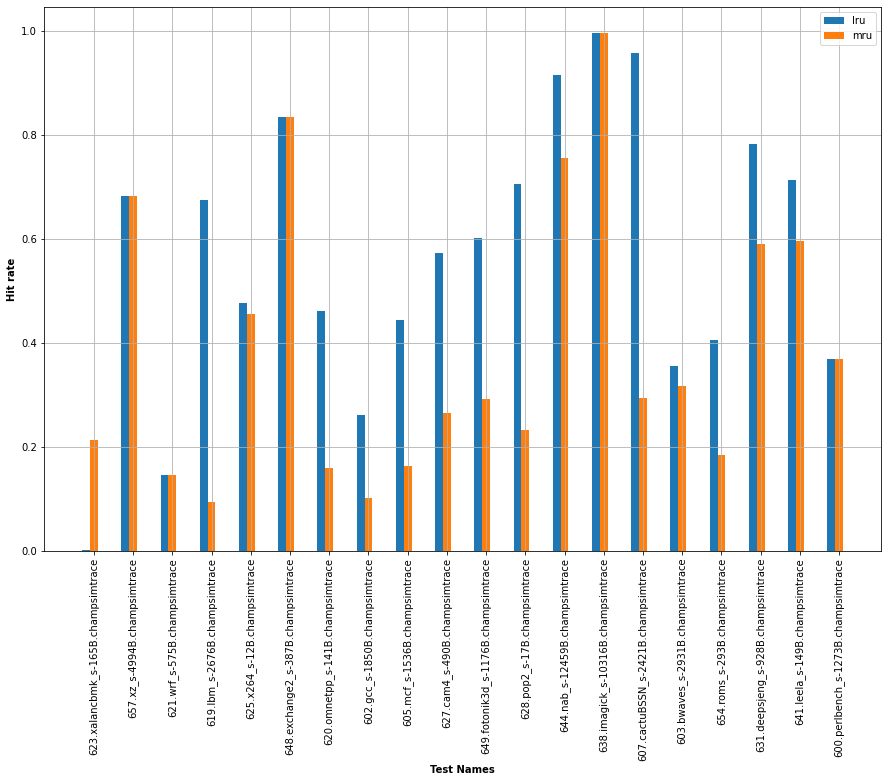

In [5]:

hrate_stats = dict(
    zip(
        stats,
        map(
            lambda v: dict(
                zip(v.stats, map(lambda x: x.hit_rate, v.stats.values()))
            ),
            stats.values(),
        ),
    )
)
ipc_stats = dict(
    zip(
        stats,
        map(
            lambda v: dict(
                zip(v.stats, map(lambda x: x.ipc, v.stats.values()))
            ),
            stats.values(),
        ),
    )
)
bar_w = 0.2
plt.figure(figsize=[15, 10])
for i, (pred, data) in enumerate(hrate_stats.items()):
    plt.bar(
        [r + bar_w * i for r in range(20)],
        data.values(),
        label=pred,
        width=bar_w,
    )
plt.xlabel("Test Names", fontweight="bold")
plt.ylabel("Hit rate", fontweight="bold")
plt.xticks(
    [r + bar_w for r in range(20)],
    list(hrate_stats.values())[0].keys(),
    rotation=90,
)
plt.grid()
plt.legend()

на многих трассах LRU имеет сильно больший процент попаданий, однако на трассе 623, MRU неожиданно сильно превосходит LRU по количеству попаданий - почти 0 против 0.2. MRU вытесняет последний использованный элемент из кэша, что портит временную локальность. Однако, как мы можем заметить, есть трассы где паттерн MRU хорошо ложится

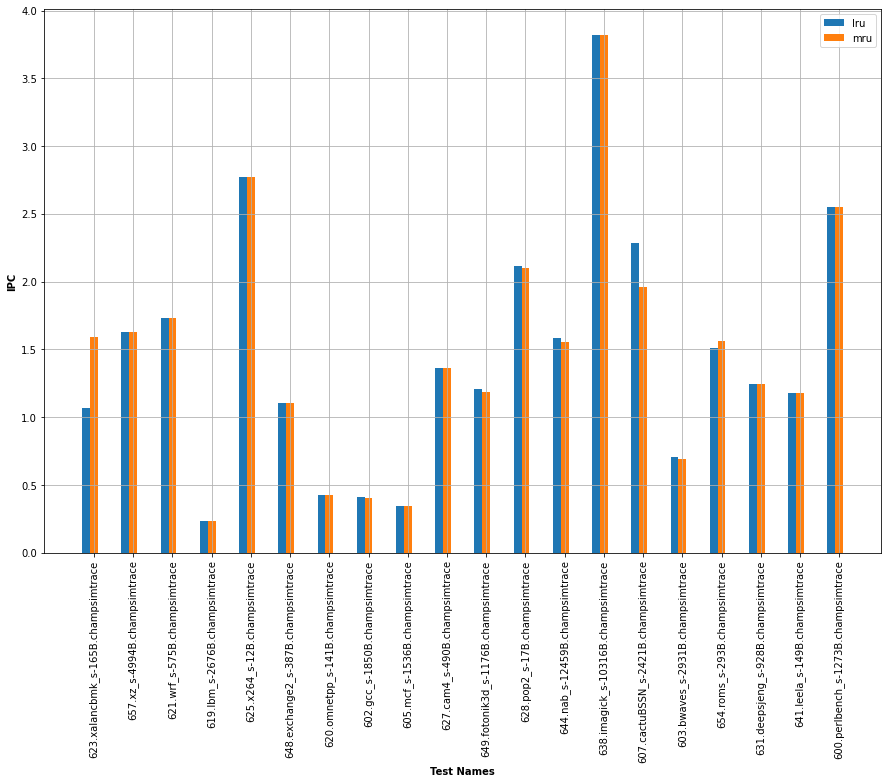

In [6]:
bar_w = 0.2
plt.figure(figsize=[15, 10])
for i, (pred, data) in enumerate(ipc_stats.items()):
    plt.bar(
        [r + bar_w * i for r in range(20)],
        data.values(),
        label=pred,
        width=bar_w,
    )
plt.xlabel("Test Names", fontweight="bold")
plt.ylabel("IPC", fontweight="bold")
plt.xticks(
    [r + bar_w for r in range(20)],
    list(ipc_stats.values())[0].keys(),
    rotation=90,
)
plt.grid()
plt.legend()

По IPC обе политики примерно одинаковы, и не дают просадки по производительности. 

# Задание 2 
Сравнение политик замещения LRU vs MRU для L2C

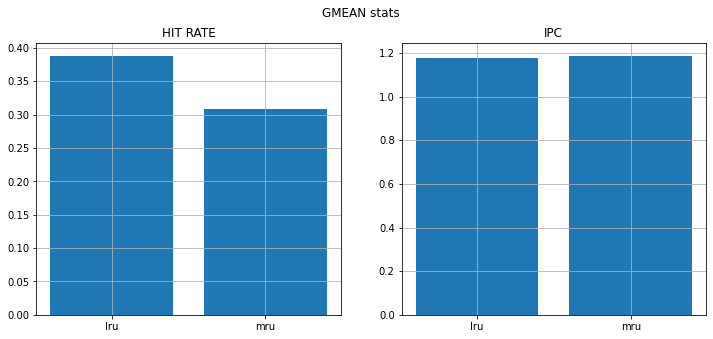

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
fig.suptitle("GMEAN stats")
ax1.set_title("HIT RATE")
ax1.bar(hrates.keys(), hrates.values())
ax1.grid()

ax2.set_title("IPC")
ax2.bar(ipcs.keys(), ipcs.values())
ax2.grid()

При рассмотрении средних значений hit rate и IPC, можно заметить что hit rate lru политики заметно выше чем для mru почти на 30%, в то время как IPC практически не изменилось.